# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

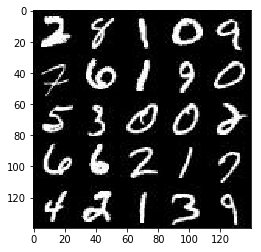

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

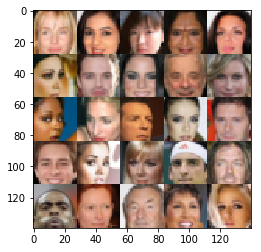

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [90]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [225]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Normalize to [-1, 1]
        img_max = tf.reduce_max(images)
        img_min = tf.reduce_min(images)
        images = 2 * ((images - img_max) / ( img_max - img_min)) - 1
        
        # Input variable 28x28x-1
        
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x128
        
        conv2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        conv3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        # Output layer
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [232]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fc, project
        fc1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape for convolution
        reshaped = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(reshaped, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        conv2 = tf.layers.conv2d_transpose(relu1, 512, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x512
        
        conv3 = tf.layers.conv2d_transpose(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x256
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 4, strides=1, padding='same')
        # 28x28xoutput_dim
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [233]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [234]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Weights & Bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [235]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [236]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]

    show_every = 100
    print_every = 10
    
    samples = []
    losses = []
    steps = 0
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    with tf.Session() as sess:
        
        input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                # encoding
                batch_images = 2*batch_images
                
                # Random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                if steps % print_every == 0:                   
                    # Get the losses, print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1084... Generator Loss: 3.3710
Epoch 1/2... Discriminator Loss: 0.1535... Generator Loss: 2.7194
Epoch 1/2... Discriminator Loss: 0.0431... Generator Loss: 5.1265
Epoch 1/2... Discriminator Loss: 2.2569... Generator Loss: 1.3205
Epoch 1/2... Discriminator Loss: 0.0889... Generator Loss: 4.6234
Epoch 1/2... Discriminator Loss: 2.8868... Generator Loss: 10.0755
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 2.4556... Generator Loss: 3.8707
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 1.5574


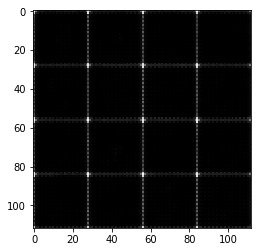

Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 1.0978
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 1.6521
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.5548
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.5181
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.6000


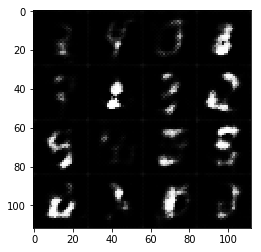

Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 2.1069
Epoch 1/2... Discriminator Loss: 1.7989... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 1.8378... Generator Loss: 0.2529
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.4216
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 1.5078


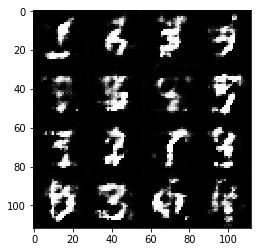

Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.1699
Epoch 1/2... Discriminator Loss: 1.8121... Generator Loss: 0.3283
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 2.0383


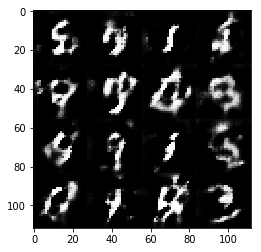

Epoch 1/2... Discriminator Loss: 0.8011... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 1.7385
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 1.8004... Generator Loss: 3.3566
Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 0.7600


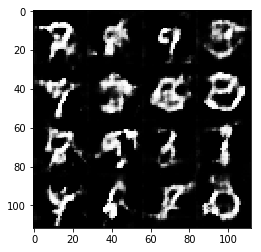

Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.8645... Generator Loss: 0.2190
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 1.6550
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.5716


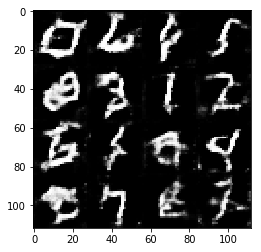

Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.6326... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.4973
Epoch 1/2... Discriminator Loss: 1.7918... Generator Loss: 0.2437
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.1170


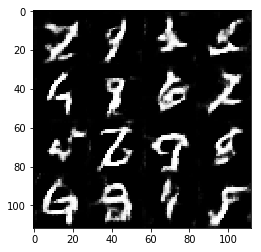

Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.3720
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.3974


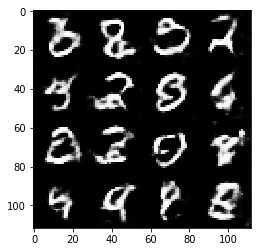

Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 2.3206
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.3622
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.5327


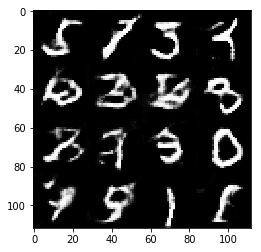

Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.5693
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.5148


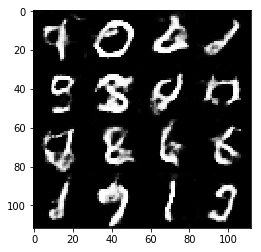

Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.2785
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.3962
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.4577
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.5898


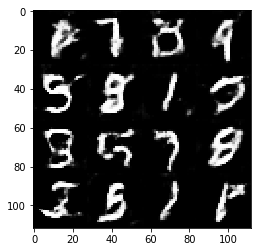

Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.3966
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 2.3171
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 0.5438


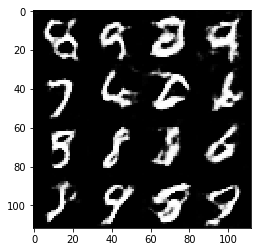

Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.7851
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 1.0038


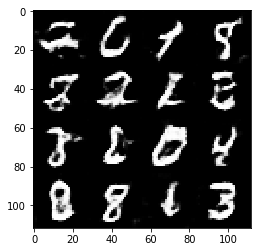

Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.7762... Generator Loss: 0.2351
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.3043
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.3981


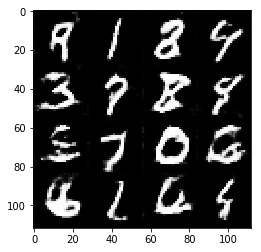

Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 1.7802
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.5525
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.1720
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 1.7022... Generator Loss: 0.3314


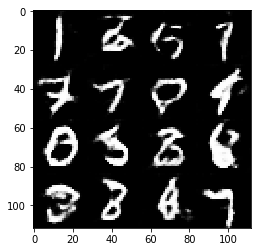

Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.6939
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 2.7009
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 0.7284


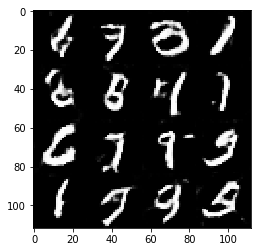

Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.9075
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.4234
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.9828... Generator Loss: 0.1971
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.3949
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 0.8538


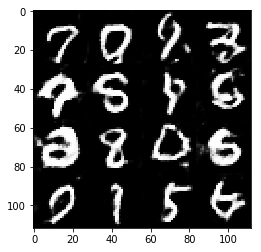

Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.6133... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 2.4527
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 1.6966... Generator Loss: 0.4063
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 0.9144


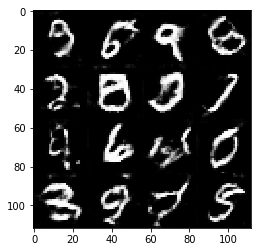

Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.4170
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.8823
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.6911


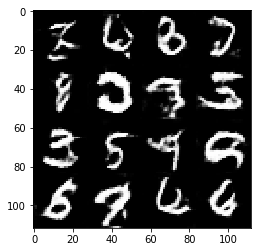

Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 1.0781


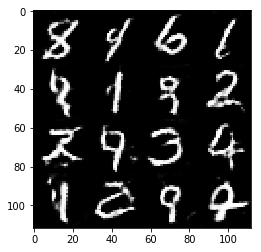

Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 1.3182
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.6137
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.6116


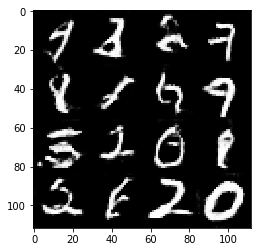

Epoch 2/2... Discriminator Loss: 1.7017... Generator Loss: 0.2920
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.0725... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.5415
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 0.3456
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.6767


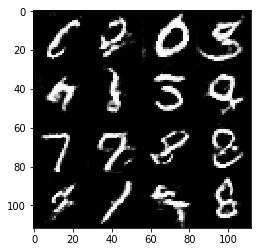

Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.6099
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 1.6027
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.5930


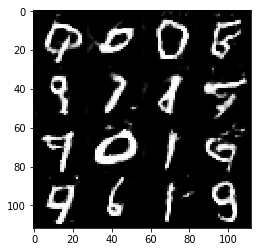

Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 1.3689
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 1.1006
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.5632
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.0041
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.5596
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 0.3644


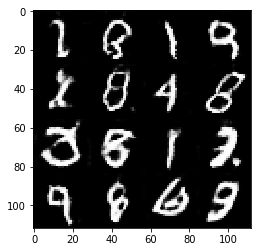

Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.3695
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.4677


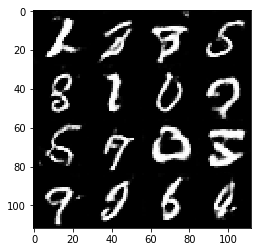

Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.2079
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.3546
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.8132


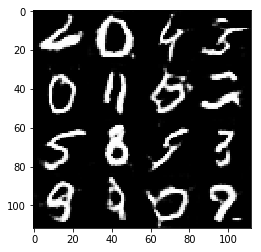

Epoch 2/2... Discriminator Loss: 1.9838... Generator Loss: 0.2022
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.0817
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 2.2202
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.9253


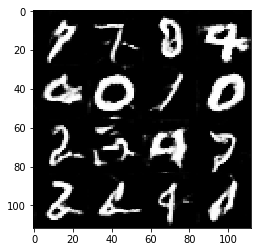

Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.4468
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.3708
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.4230
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.2488
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 2.5648
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.4563


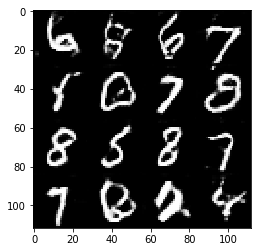

Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.1219... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.6978... Generator Loss: 0.3377
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.7816... Generator Loss: 0.2733
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.4937


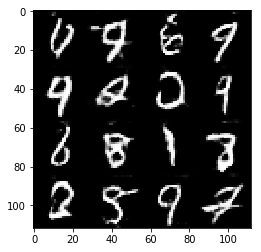

Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 0.6931... Generator Loss: 1.2628
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 1.4393
Epoch 2/2... Discriminator Loss: 1.4699... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.6197


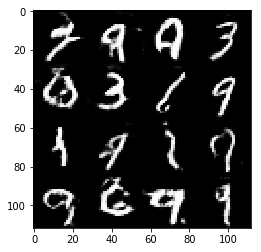

Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.0024
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.8462... Generator Loss: 0.2371
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 1.7047... Generator Loss: 0.2997
Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 0.3459
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.5697
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.2777


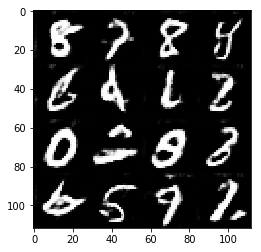

Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 1.4687
Epoch 2/2... Discriminator Loss: 1.8384... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.5365


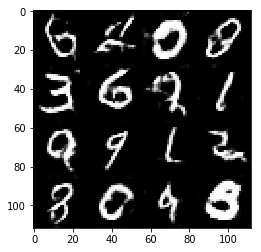

Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.5118
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 2.6524
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.5525
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 0.5902


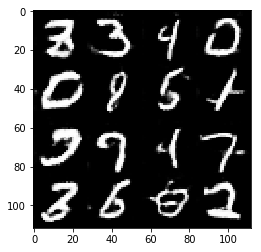

Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.9181
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.6278
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 0.8831
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.5900
Epoch 2/2... Discriminator Loss: 1.8348... Generator Loss: 0.2336
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.3717
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.3041
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.4614


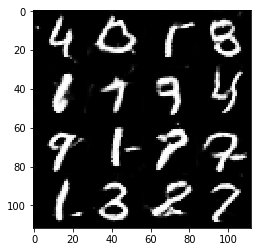

Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.7946
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.4625
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 1.4958... Generator Loss: 0.4030


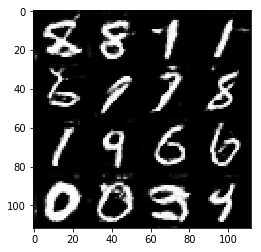

Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.3970
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 2.4296
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.5399
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.7239... Generator Loss: 0.3099


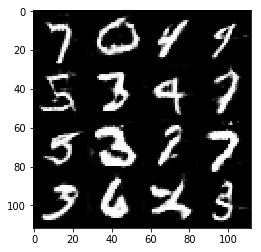

Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.1293
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.2637
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 1.3491
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.1528
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.6381


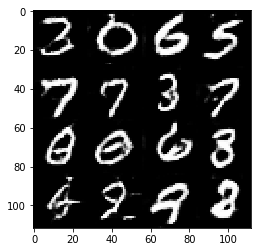

Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.5140


In [238]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1125... Generator Loss: 0.2461
Epoch 1/1... Discriminator Loss: 2.4369... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 1.8819
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 3.6083
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 3.0503
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.3155
Epoch 1/1... Discriminator Loss: 0.0652... Generator Loss: 3.3519
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 2.3467


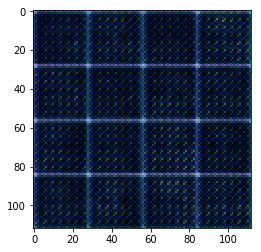

Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.6906
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 3.6685
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 4.4192
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 4.1265
Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 2.8174
Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 4.1286
Epoch 1/1... Discriminator Loss: 1.7984... Generator Loss: 0.2218
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 5.4137
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 3.9654


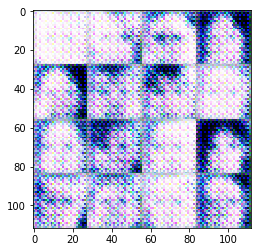

Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 2.8635
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 0.1478... Generator Loss: 2.9860
Epoch 1/1... Discriminator Loss: 0.1364... Generator Loss: 2.5752
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 4.5488
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 2.1339
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 3.8175
Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 5.5806
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.0612
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 3.4278


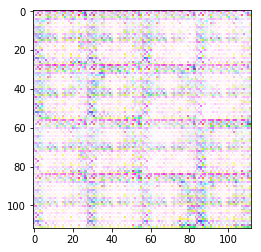

Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 5.7613
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 3.6097
Epoch 1/1... Discriminator Loss: 2.0575... Generator Loss: 0.1513
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 6.5735
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 3.8696
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 2.4215... Generator Loss: 0.1167
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 0.2694
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.3533


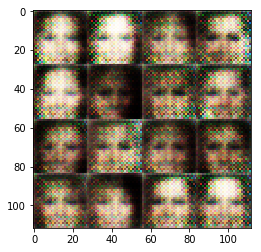

Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 2.0375
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 2.1130... Generator Loss: 0.1575
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 0.2576
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.2798


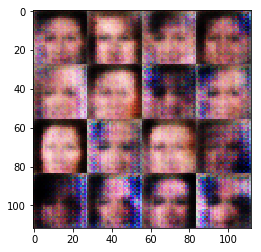

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.9938... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 1.1789


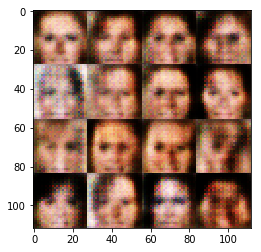

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.6733
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 2.0613... Generator Loss: 0.1856
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.2904
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 2.0398... Generator Loss: 0.1600
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.1990


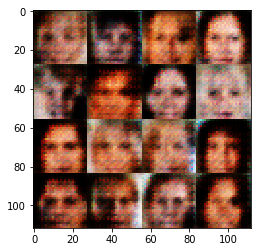

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 2.3646
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.4012


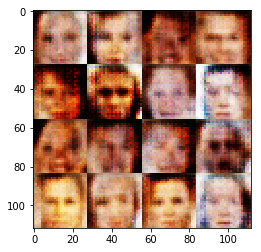

Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 2.2340... Generator Loss: 0.1282
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 2.2087... Generator Loss: 2.9667
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.3698


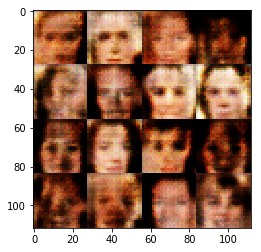

Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 2.1574... Generator Loss: 0.1444
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.3045


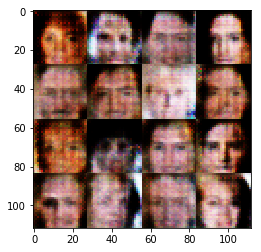

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 2.8438
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.9511


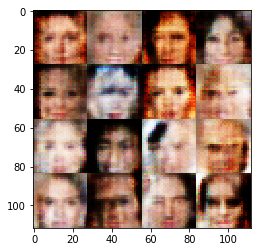

Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 2.6430... Generator Loss: 2.9048
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8345


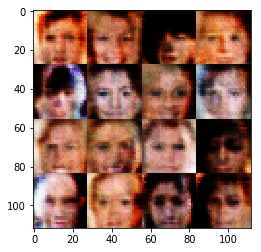

Epoch 1/1... Discriminator Loss: 1.7873... Generator Loss: 2.0354
Epoch 1/1... Discriminator Loss: 2.1159... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 2.0101
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.5269


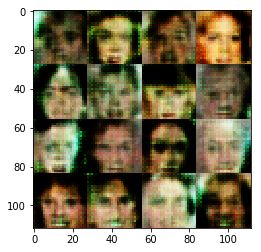

Epoch 1/1... Discriminator Loss: 0.2776... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.7145... Generator Loss: 1.8318
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.3197
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.3848


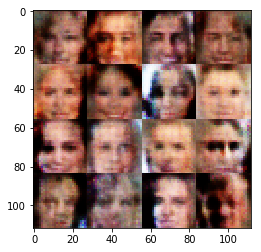

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5265


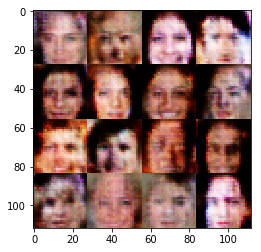

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.7540... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.9218... Generator Loss: 3.1994
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.6241


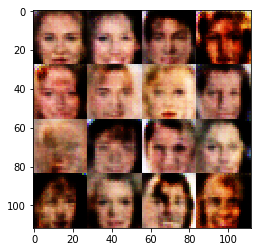

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.6875... Generator Loss: 1.9893
Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 2.2902
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.0203


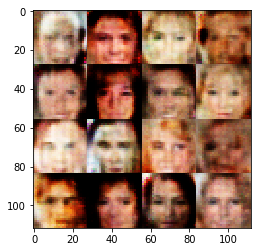

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7303


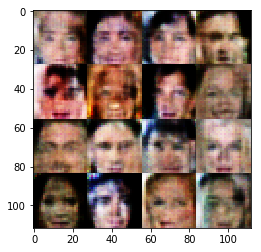

Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.9171
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 3.2411


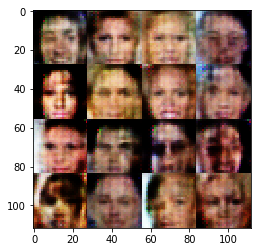

Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.5714


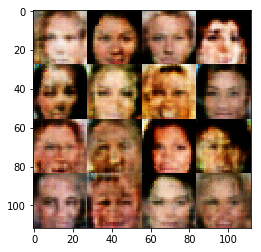

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 2.3373... Generator Loss: 2.3215
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6210


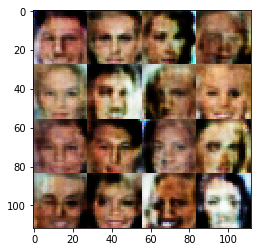

Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 2.1020... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.6731
Epoch 1/1... Discriminator Loss: 2.7583... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.5434


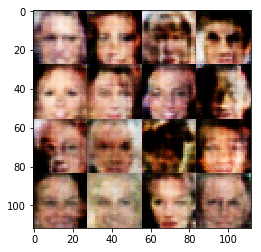

Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.7720
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 2.1466... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.8891


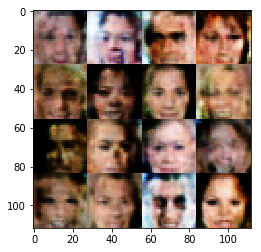

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.3044
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.7415
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.6176


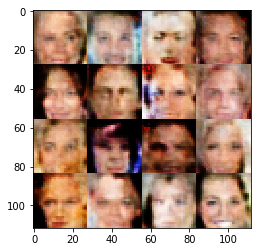

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.1207


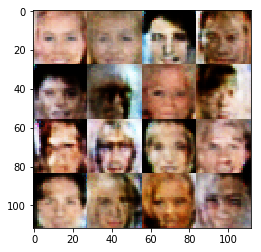

Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.9979... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6182


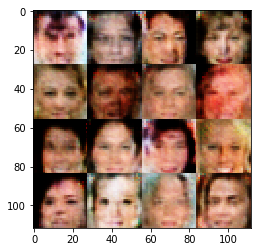

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.5834


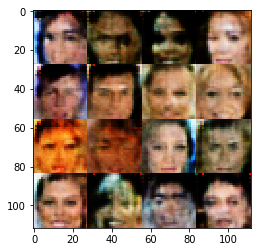

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.8077... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 0.8788


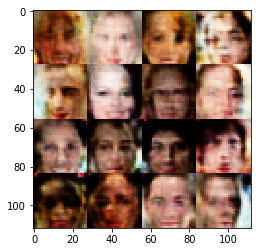

Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.9839... Generator Loss: 0.2176
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.3452
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.3355


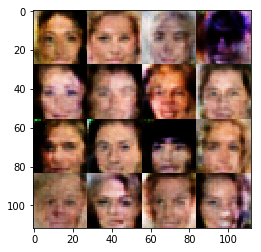

Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.2243


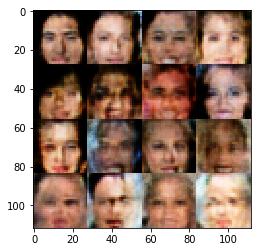

Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.2829


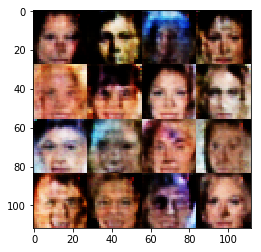

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.4468
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8890


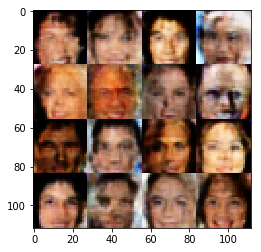

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 1.4646
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8815


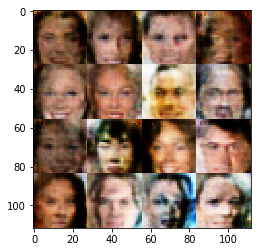

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 2.0646... Generator Loss: 0.1584
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8668


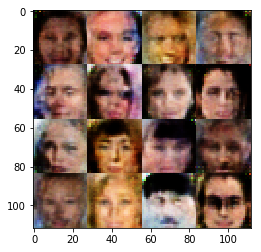

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.6698


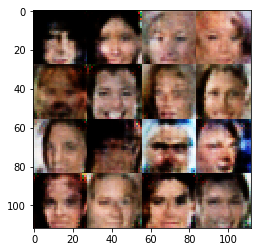

Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.8653
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.6387
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6864


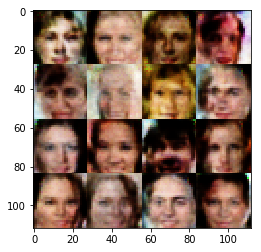

Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 2.4732
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.7626


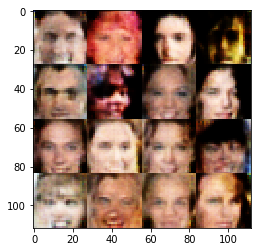

Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.9799... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.5993


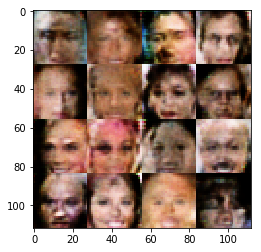

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 2.1484... Generator Loss: 2.0474
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.4503


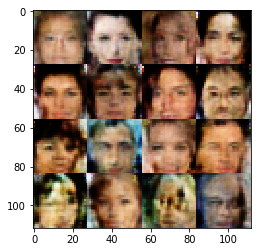

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 1.8680... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4916


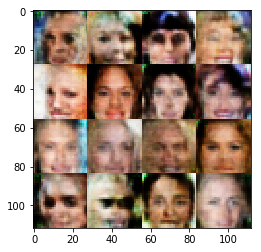

Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 2.3091... Generator Loss: 0.1419
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4084


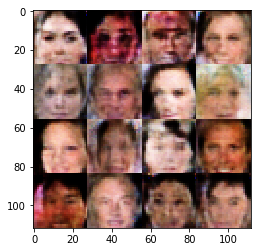

Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.8607


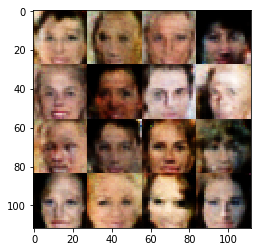

Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 1.7955
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 2.9649


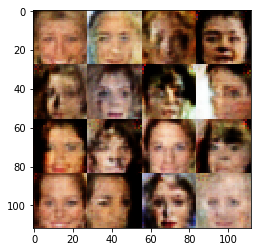

Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 2.1774... Generator Loss: 0.1373
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 0.8203


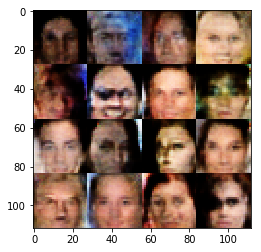

Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.3075
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.4979


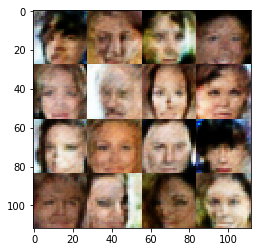

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.7902
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 1.6162


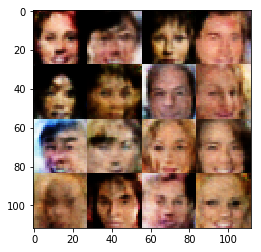

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7999


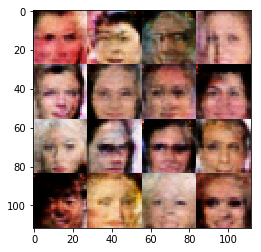

Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8444


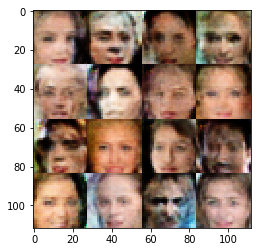

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.7243


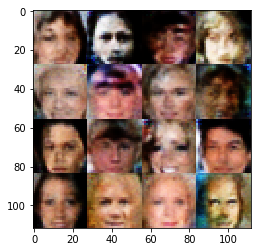

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.3352
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.3166
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 1.5564
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.3968


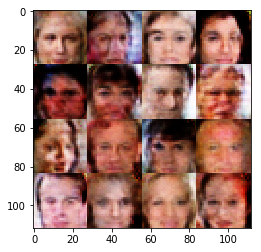

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.1864


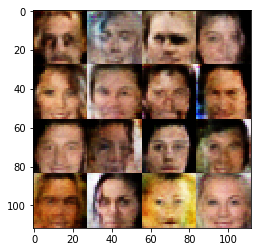

Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.3105
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.5212


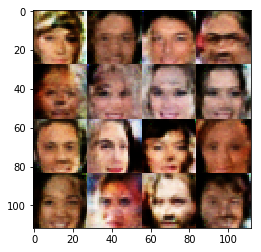

Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.9219


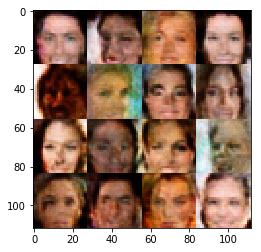

Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.9276... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 0.9094


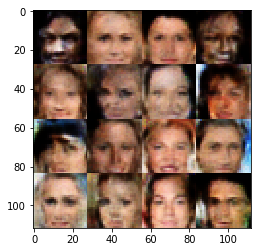

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.4268
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.0989


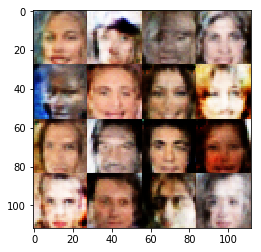

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 1.5244
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 0.9546


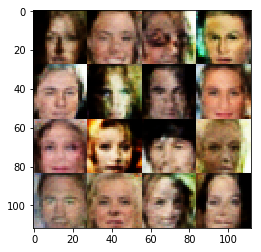

Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 2.6670... Generator Loss: 2.8127
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.5441
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.5629


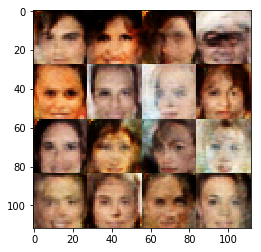

Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.3536
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8171


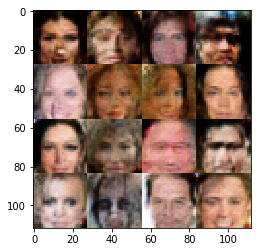

Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6145


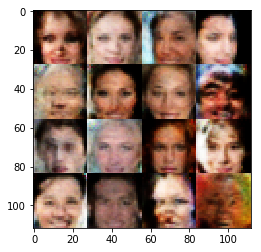

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.2330
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 0.1914
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.4807


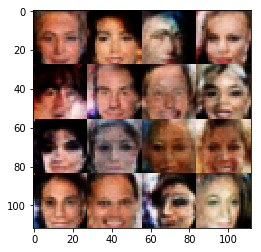

Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 1.4239


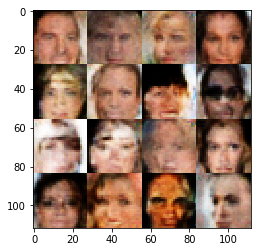

Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.5825


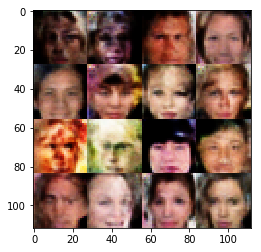

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8492


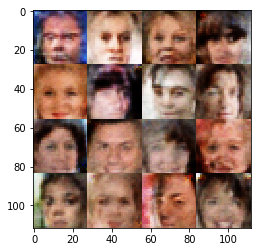

Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8166


In [237]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.